<a href="https://colab.research.google.com/github/abhinavaditya811/Customer-Segmentation/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('./data.csv', encoding='ISO-8859-1')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.shape

(541909, 8)

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'InvoiceNo'),
  Text(1, 0, 'StockCode'),
  Text(2, 0, 'Description'),
  Text(3, 0, 'Quantity'),
  Text(4, 0, 'InvoiceDate'),
  Text(5, 0, 'UnitPrice'),
  Text(6, 0, 'CustomerID'),
  Text(7, 0, 'Country')])

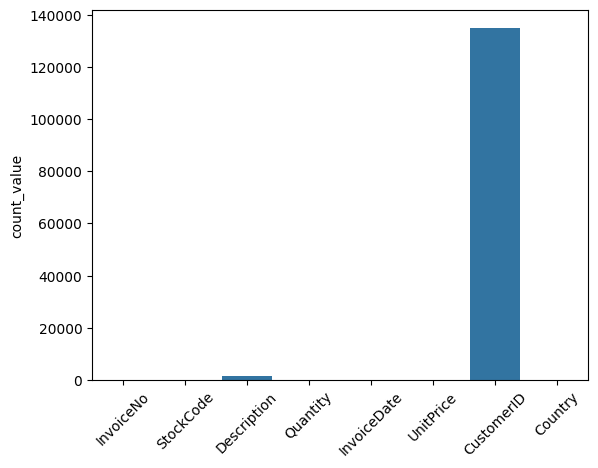

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

null_values = pd.DataFrame(df.isnull().sum(),columns=['count_value'])
ax = sns.barplot(null_values.count_value)

plt.xticks(rotation=45)

In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


The CustomerID column contains nearly a quarter of missing data. This column is essential for clustering customers and creating a recommendation system. Imputing such a large percentage of missing values might introduce significant bias or noise into the analysis.

Moreover, since the clustering is based on customer behavior and preferences, it's crucial to have accurate data on customer identifiers. Therefore, removing the rows with missing CustomerIDs seems to be the most reasonable approach to maintain the integrity of the clusters and the analysis.

In [ ]:
df = df.dropna(subset=['CustomerID', 'Description'])

In [ ]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [ ]:
df.shape[0]

401604

# Treating Cancelled Transactions

In [ ]:
import numpy as np

df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


In [ ]:
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.21%


In [ ]:
unique_stock_codes = df['StockCode'].nunique()

print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3684


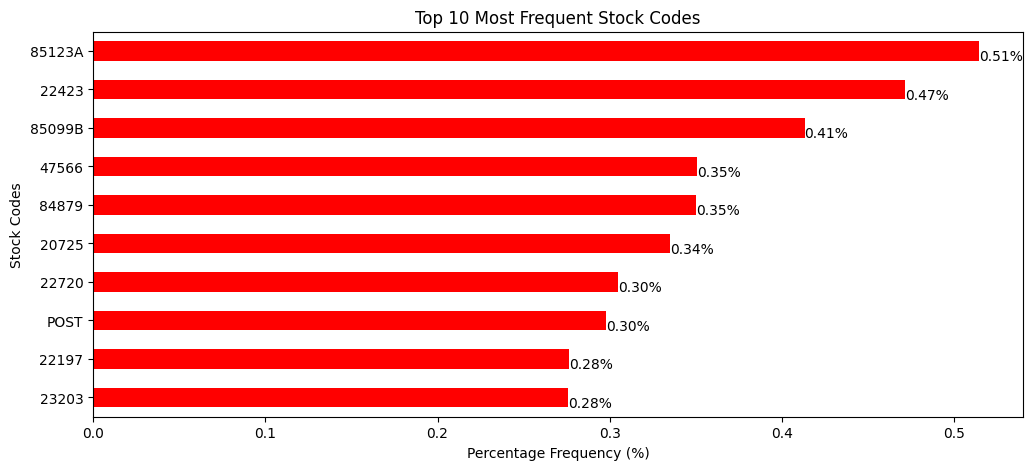

In [ ]:
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='red')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Value counts of numeric character frequencies in unique stock codes:")
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
5    3676
0       7
1       1
Name: count, dtype: int64


In [ ]:
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

print("Anomalous stock codes:")
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [ ]:
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


In [ ]:
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [ ]:
df.shape

(399689, 9)

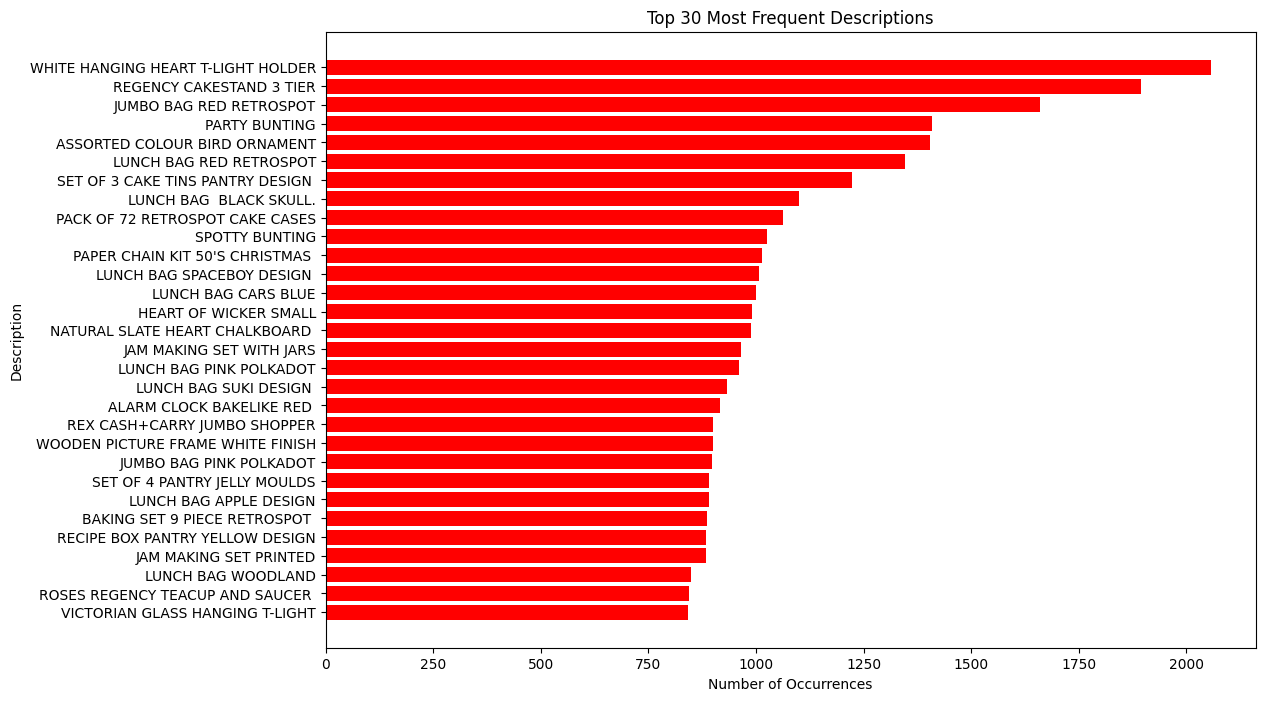

In [ ]:
# Cleaning description column
description_counts = df['Description'].value_counts()

top_30_descriptions = description_counts[:30]

plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='red')
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')
plt.show()

In [ ]:
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

print("The unique descriptions containing lowercase characters are:")
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [ ]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

df = df[~df['Description'].isin(service_related_descriptions)]

df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [ ]:
df.shape

(399606, 9)

In [ ]:
# Treating zero unit prices
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [ ]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

In [ ]:
df.shape

(399573, 9)

In [ ]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

# Recency(R)

In [ ]:
df['CustomerID'] = df['CustomerID'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['InvoiceDay'] = df['InvoiceDate'].dt.date

start_date = df['InvoiceDate'].min()
end_date = df['InvoiceDate'].max()
print(f"Period covered by the dataset: {start_date} to {end_date}")

Period covered by the dataset: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


In [ ]:
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

In [ ]:
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])

In [ ]:
customer_data['Days_Since_Last_Purchase'] = (end_date - customer_data['InvoiceDay']).dt.days
customer_data.drop(columns=['InvoiceDay'], inplace=True)
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


# Frequency(F)

In [ ]:
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346,325,2,0
1,12347,2,7,2458
2,12348,75,4,2332
3,12349,18,1,630
4,12350,310,1,196


# Monetary(M)

In [ ]:
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346,325,2,0,0.00,0.000000
1,12347,2,7,2458,4310.00,615.714286
2,12348,75,4,2332,1437.24,359.310000
3,12349,18,1,630,1457.55,1457.550000
4,12350,310,1,196,294.40,294.400000


In [ ]:
rfm = pd.DataFrame(customer_data)[['CustomerID', 'Days_Since_Last_Purchase', 'Total_Transactions', 'Total_Spend']].rename(columns={
    'Days_Since_Last_Purchase': 'Recency',
    'Total_Transactions': 'Frequency',
    'Total_Spend': 'Monetary'
})

rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346,325,2,0.00
1,12347,2,7,4310.00
2,12348,75,4,1437.24
3,12349,18,1,1457.55
4,12350,310,1,294.40


In [ ]:
rfm.set_index('CustomerID',inplace=True)

In [ ]:
# Display data types of all columns in the rfm DataFrame
# Display a summary of the rfm DataFrame, including data types and non-null counts
print(rfm.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4362 entries, 12346 to 18287
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4362 non-null   int64  
 1   Frequency  4362 non-null   int64  
 2   Monetary   4362 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 136.3 KB
None


In [ ]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,16.0,1.0,292.3725
0.50,50.0,3.0,641.7850
0.75,143.0,5.0,1584.7450


In [ ]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4

In [ ]:
#create rfm segmentation table
rfm_segmentation = rfm.copy()
rfm_segmentation['R_Score'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Score'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Score'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [ ]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
CustomerID,,,,,,
12346,325,2,0.00,1,2,1
12347,2,7,4310.00,4,4,4
12348,75,4,1437.24,2,3,3
12349,18,1,1457.55,3,1,3
12350,310,1,294.40,1,1,2


In [ ]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Score.map(str) \
                            + rfm_segmentation.F_Score.map(str) \
                            + rfm_segmentation.M_Score.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFMScore
CustomerID,,,,,,,
12346,325,2,0.00,1,2,1,121
12347,2,7,4310.00,4,4,4,444
12348,75,4,1437.24,2,3,3,233
12349,18,1,1457.55,3,1,3,313
12350,310,1,294.40,1,1,2,112


In [ ]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFMScore
CustomerID,,,,,,,
14646,1,73,278778.02,4,4,4,444
18102,0,60,259657.30,4,4,4,444
17450,8,49,189575.53,4,4,4,444
14911,1,242,128768.24,4,4,4,444
14156,9,64,113685.77,4,4,4,444
17511,2,45,88138.20,4,4,4,444
16684,4,30,65920.12,4,4,4,444
13694,3,57,62961.54,4,4,4,444
15311,0,118,59284.19,4,4,4,444


In [ ]:
# Function to label RFM segments based on RFMScore values
def label_rfm(row):
    # Champions: High Recency, Frequency, and Monetary
    if row['RFMScore'] == '444':
        return 'Champion'
    # Loyal Customers: High Frequency and Monetary but moderate Recency
    elif row['RFMScore'] in ['344', '434', '443', '433']:
        return 'Loyal Customer'
    # Potential Loyalists: Recent purchases with good Frequency and Monetary scores
    elif row['RFMScore'] in ['244', '344', '343']:
        return 'Potential Loyalist'
    # New Customers: Very recent with low Frequency and Monetary scores
    elif row['RFMScore'] in ['411', '412', '413']:
        return 'New Customer'
    # Promising: Moderate Recency, Frequency, and Monetary scores
    elif row['RFMScore'] in ['323', '332', '333']:
        return 'Promising'
    # At Risk: Low Recency with high Frequency or Monetary, indicating past engagement
    elif row['RFMScore'] in ['134', '234', '334']:
        return 'At Risk'
    # Cannot Lose Them: High Monetary and Frequency with low Recency
    elif row['RFMScore'] in ['144', '244']:
        return 'Cannot Lose Them'
    # About to Sleep: Low Recency and low Frequency but moderate Monetary
    elif row['RFMScore'] in ['222', '223', '224']:
        return 'About to Sleep'
    # Hibernating: Low Recency, Frequency, and Monetary
    elif row['RFMScore'] in ['111', '112', '113']:
        return 'Hibernating'
    # Lost: Customers who have not made recent purchases and show low engagement
    elif row['RFMScore'] in ['121', '131', '211']:
        return 'Lost'
    else:
        return 'Other'

# Apply the segmentation function based on the RFMScore column
rfm_segmentation['Segment'] = rfm_segmentation.apply(label_rfm, axis=1)

# Display the segmented DataFrame
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFMScore,Segment
CustomerID,,,,,,,,
12346,325,2,0.00,1,2,1,121,Lost
12347,2,7,4310.00,4,4,4,444,Champion
12348,75,4,1437.24,2,3,3,233,Other
12349,18,1,1457.55,3,1,3,313,Other
12350,310,1,294.40,1,1,2,112,Hibernating


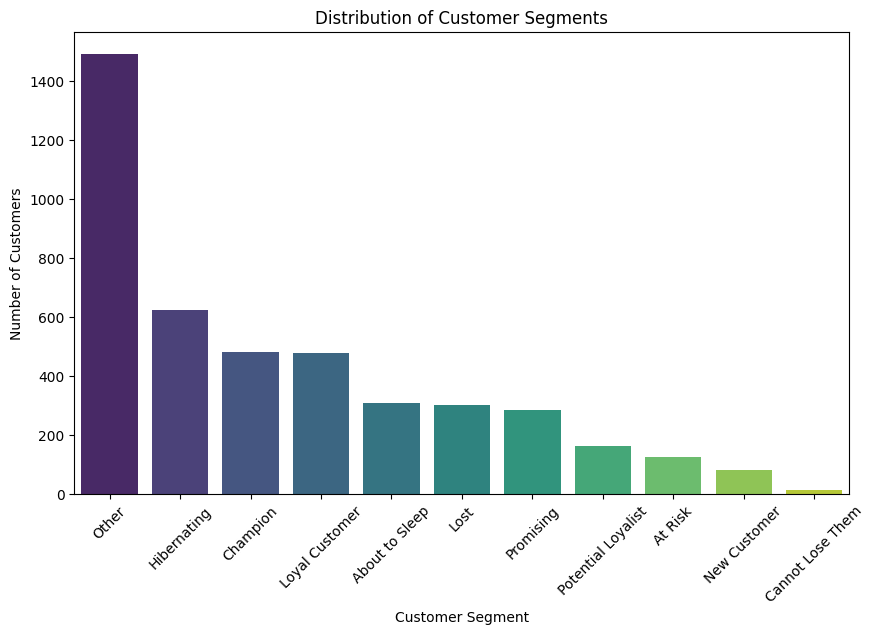

In [ ]:
# Count customers in each segment
segment_counts = rfm_segmentation['Segment'].value_counts()

# Plot the distribution of customer segments
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.barplot(y=segment_counts.values, x=segment_counts.index, hue=segment_counts.index, palette='viridis', dodge=False, legend=False)
plt.xlabel("Customer Segment")
plt.ylabel("Number of Customers")
plt.title("Distribution of Customer Segments")
plt.xticks(rotation=45)
plt.show()

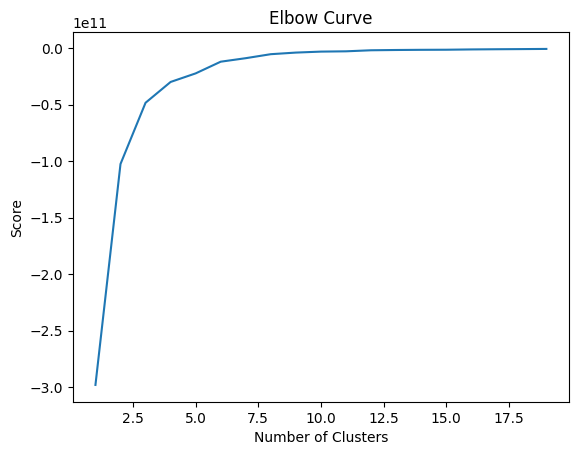

In [ ]:
from sklearn.cluster import KMeans
# get right number of cluster for K-means so we neeed to loop from 1 to 20 number of cluster and check score.
#Elbow method is used to represnt that.
cluster_range = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in cluster_range]
score = [kmeans[i].fit(rfm).score(rfm) for i in range(len(kmeans))]
plt.plot(cluster_range,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
#fitting data in Kmeans theorem.
kmeans = KMeans(n_clusters=3, random_state=0).fit(rfm)

rfm['cluster'] = kmeans.labels_

rfm[rfm.cluster == 0].head(10)

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346,325,2,0.00,0
12347,2,7,4310.00,0
12348,75,4,1437.24,0
12349,18,1,1457.55,0
12350,310,1,294.40,0
12352,36,8,1265.41,0
12353,204,1,89.00,0
12354,232,1,1079.40,0
12355,214,1,459.40,0


<Axes: xlabel='cluster', ylabel='Recency'>

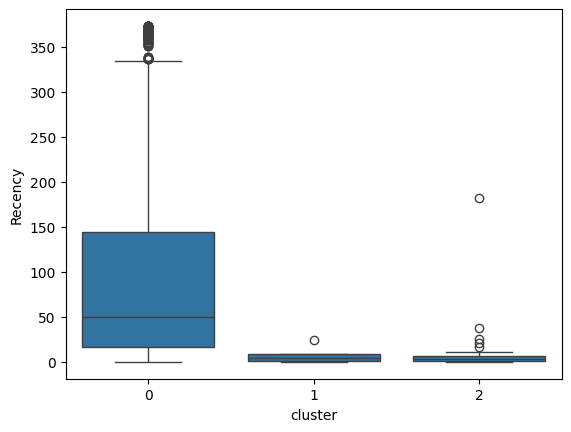

In [ ]:
sns.boxplot(x='cluster', y='Recency', data=rfm)

Low recency rate in cluster 1 and 2.

<Axes: xlabel='cluster', ylabel='Frequency'>

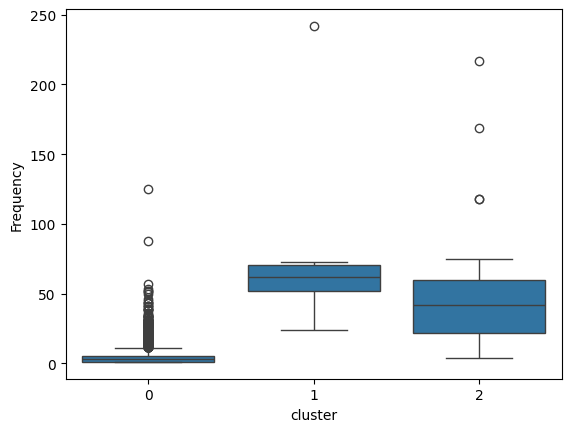

In [ ]:
sns.boxplot(x='cluster', y='Frequency', data=rfm)

Low frequency in cluster 0.

<Axes: xlabel='cluster', ylabel='Monetary'>

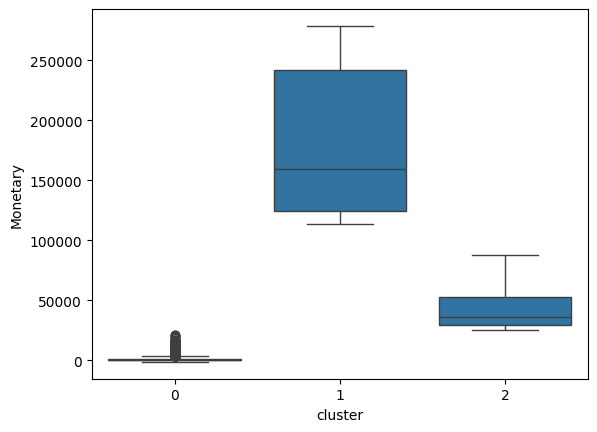

In [ ]:
sns.boxplot(x='cluster', y='Monetary', data=rfm)

Cluster 1 has the highest monetary value.

**This clustering does not differentiate between the customers and their assigned clusters properly so we will clean the data a bit more and perform Principal Component Analysis(PCA) to get better clusters.**

# EDA of customers and different features

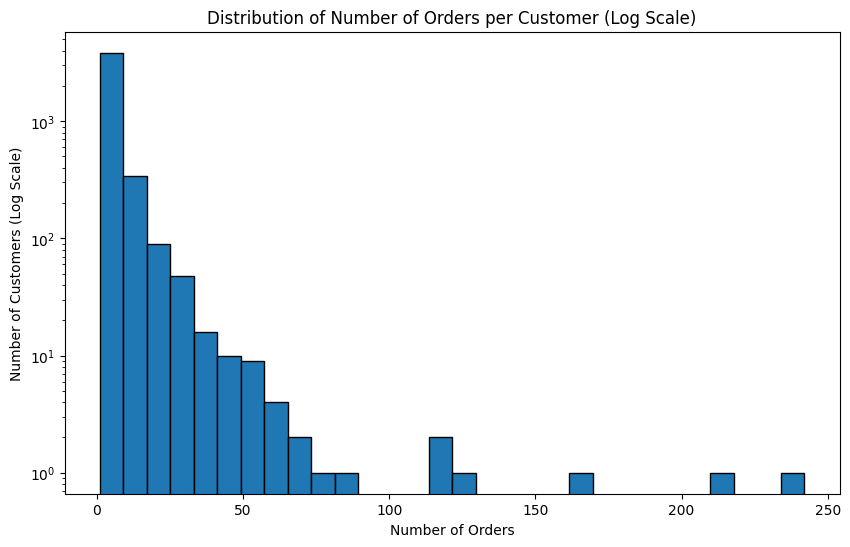

In [ ]:
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique()

# Plot the distribution with a log scale on the x-axis
plt.figure(figsize=(10, 6))
plt.hist(orders_per_customer, bins=30, edgecolor='k', log=True)  # Set log=True for y-axis
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers (Log Scale)')
plt.title('Distribution of Number of Orders per Customer (Log Scale)')
plt.show()

In [ ]:
# Calculate the number of unique orders per customer
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique()
top_customers = orders_per_customer.sort_values(ascending=False).head(5)
print("Top 5 customers by order count:")
print(top_customers)

Top 5 customers by order count:
CustomerID
14911    242
12748    217
17841    169
14606    125
13089    118
Name: InvoiceNo, dtype: int64


In [ ]:
# Group by product and sum the Quantity to get the total purchased units per product
top_products = df.groupby('Description')['Quantity'].sum()
# Sort the products by total Quantity in descending order and select the top 10
top_10_products = top_products.sort_values(ascending=False).head(10)
print("Top 10 most frequently purchased products:")
print(top_10_products)

Top 10 most frequently purchased products:
Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53119
JUMBO BAG RED RETROSPOT               44963
ASSORTED COLOUR BIRD ORNAMENT         35215
WHITE HANGING HEART T-LIGHT HOLDER    34128
PACK OF 72 RETROSPOT CAKE CASES       33386
POPCORN HOLDER                        30492
RABBIT NIGHT LIGHT                    27045
MINI PAINT SET VINTAGE                25880
PACK OF 12 LONDON TISSUES             25305
PACK OF 60 PINK PAISLEY CAKE CASES    24129
Name: Quantity, dtype: int64


In [ ]:
# Calculate the average price of products
average_price = df['UnitPrice'].mean()

print(f"The average price of products in the dataset is: {average_price:.2f}")

The average price of products in the dataset is: 2.91


In [ ]:
product_revenue = df.groupby('Description')['Total_Spend'].sum()
#Sort the products by revenue to find the highest revenue-generating product
top_product = product_revenue.sort_values(ascending=False).head(1)
print("Product generating the highest revenue:")
print(top_product)

Product generating the highest revenue:
Description
REGENCY CAKESTAND 3 TIER    132567.7
Name: Total_Spend, dtype: float64


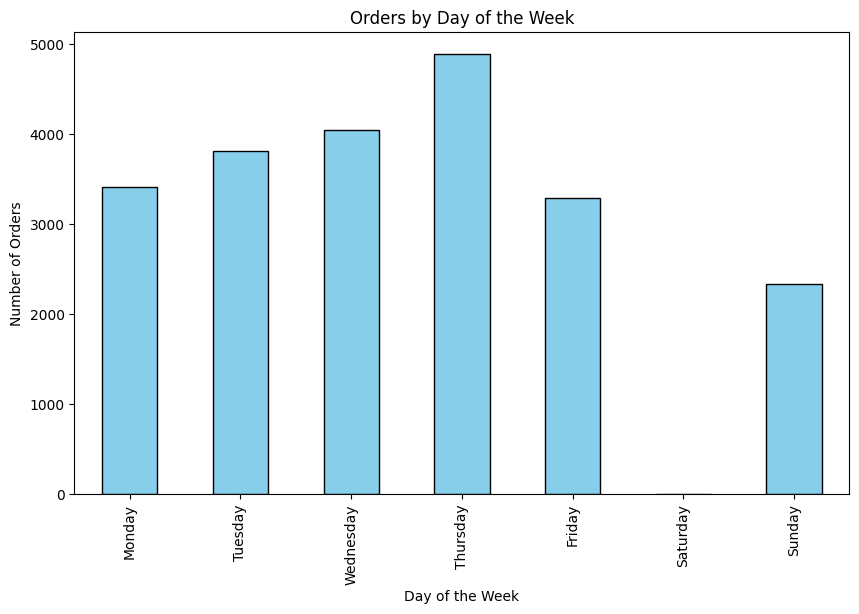

In [ ]:
# Extract the day of the week and hour from the InvoiceDate
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()  # Get day names (e.g., 'Monday', 'Tuesday')
df['Hour'] = df['InvoiceDate'].dt.hour  # Get the hour of the day
# Count the number of orders placed on each day of the week
orders_by_day = df.groupby('DayOfWeek')['InvoiceNo'].nunique().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the distribution of orders by day of the week
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
orders_by_day.plot(kind='bar', color='skyblue', edgecolor='k')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Orders')
plt.title('Orders by Day of the Week')
plt.show()

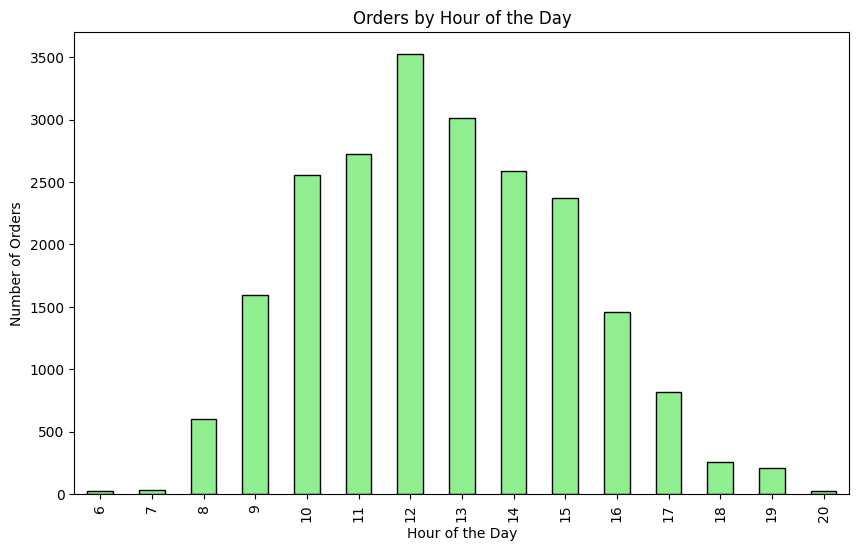

In [ ]:
# Count the number of orders placed during each hour of the day
orders_by_hour = df.groupby('Hour')['InvoiceNo'].nunique()

# Plot the distribution of orders by hour of the day
plt.figure(figsize=(10, 6))
orders_by_hour.plot(kind='bar', color='lightgreen', edgecolor='k')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Orders')
plt.title('Orders by Hour of the Day')
plt.show()

In [ ]:
# Ensure InvoiceDate is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extract year and month from the InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')  # Creates a YYYY-MM format

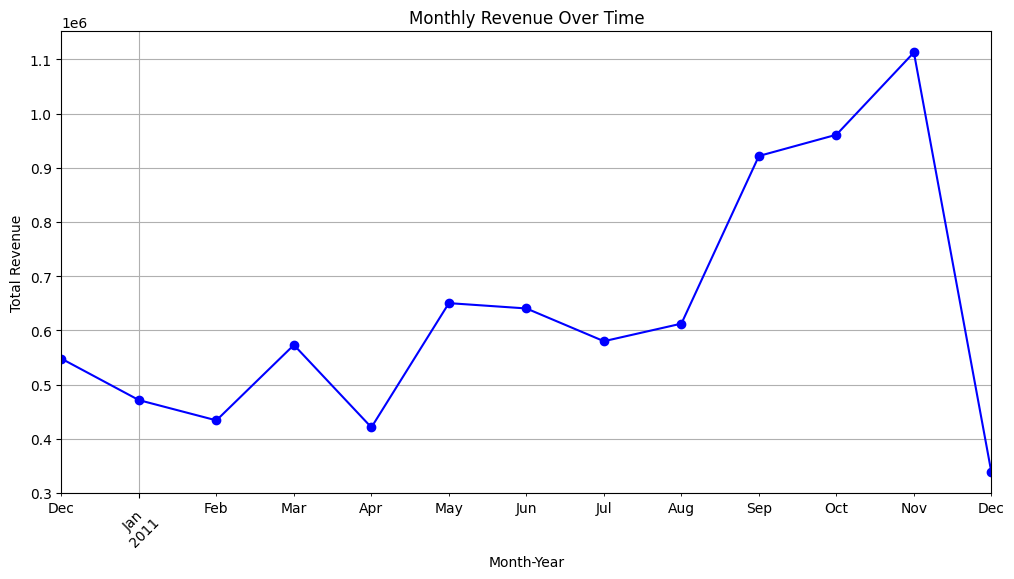

In [ ]:
monthly_revenue = df.groupby('MonthYear')['Total_Spend'].sum()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
monthly_revenue.plot(kind='line', marker='o', color='b')
plt.title('Monthly Revenue Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

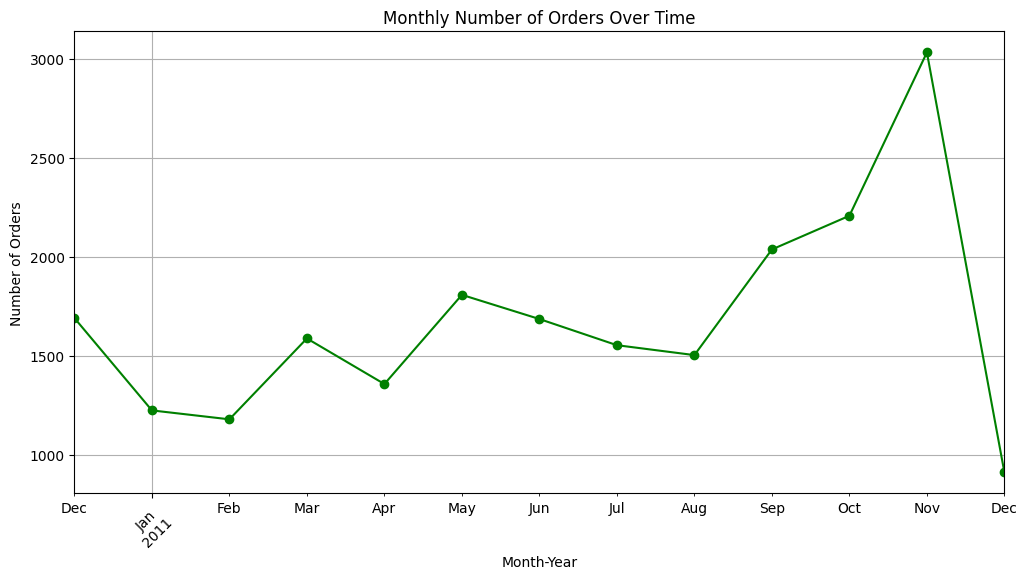

In [ ]:
# Calculate the number of orders per month
monthly_orders = df.groupby('MonthYear')['InvoiceNo'].nunique()

plt.figure(figsize=(12, 6))
monthly_orders.plot(kind='line', marker='o', color='g')
plt.title('Monthly Number of Orders Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
top_countries = df.groupby('Country')['InvoiceNo'].nunique()

# Sort the countries by the number of orders in descending order and get the top 5
top_5_countries = top_countries.sort_values(ascending=False).head(5)

print("Top 5 countries with the highest number of orders:")
print(top_5_countries)

Top 5 countries with the highest number of orders:
Country
United Kingdom    19578
Germany             577
France              438
EIRE                311
Belgium             117
Name: InvoiceNo, dtype: int64


<ipython-input-61-151a3abe5ab2>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='AverageOrderValue', y='Country', data=country_aov_df, palette='YlGnBu')


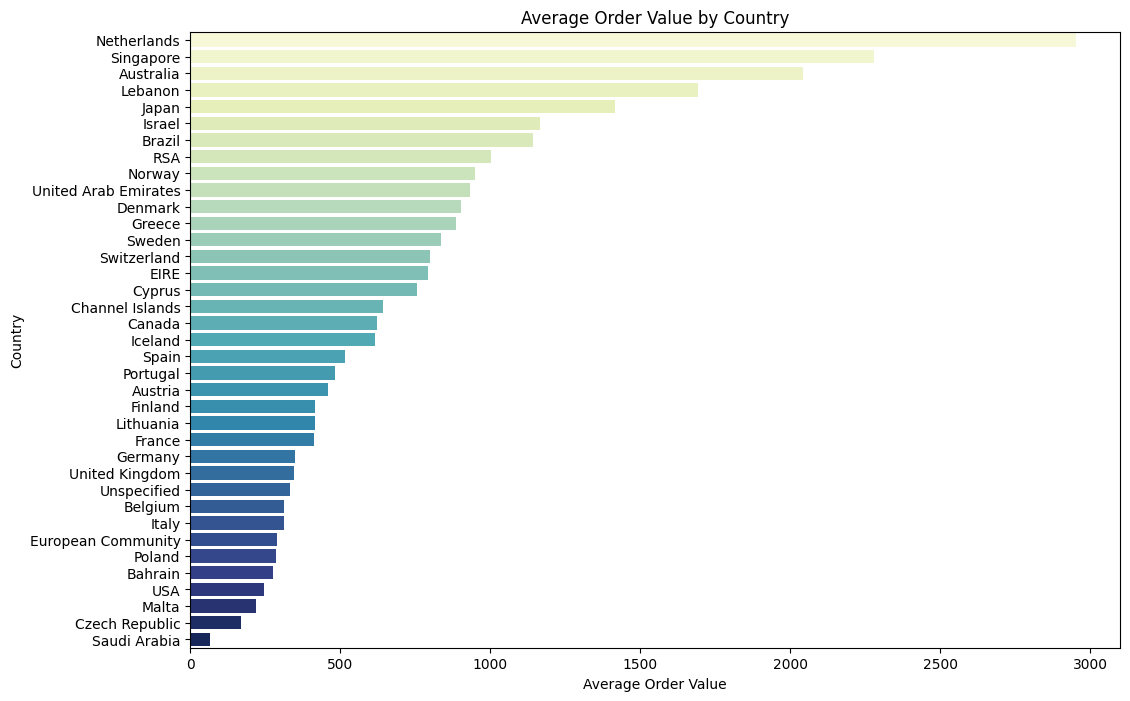

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

country_revenue = df.groupby('Country')['Total_Spend'].sum()
country_orders = df.groupby('Country')['InvoiceNo'].nunique()

# Step 3: Calculate Average Order Value (AOV) for each country
country_aov = country_revenue / country_orders
country_aov_df = country_aov.reset_index()
country_aov_df.columns = ['Country', 'AverageOrderValue']

# Step 4: Sort by AverageOrderValue for better visualization
country_aov_df = country_aov_df.sort_values(by='AverageOrderValue', ascending=False)

# Step 5: Plot the data using a horizontal bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='AverageOrderValue', y='Country', data=country_aov_df, palette='YlGnBu')
plt.xlabel('Average Order Value')
plt.ylabel('Country')
plt.title('Average Order Value by Country')
plt.show()

In [ ]:
# Ensure InvoiceDate is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Group by CustomerID to get the first and last purchase dates
customer_activity = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
customer_activity.columns = ['FirstPurchaseDate', 'LastPurchaseDate']
# Calculate the difference between last and first purchase dates in days
customer_activity['ActiveDuration'] = (customer_activity['LastPurchaseDate'] - customer_activity['FirstPurchaseDate']).dt.days
# Calculate the average active duration
average_active_duration = customer_activity['ActiveDuration'].mean()

print(f"The average active duration of customers is: {average_active_duration:.2f} days")

The average active duration of customers is: 133.23 days


In [ ]:
# Product diversity
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346,325,2,0,0.00,0.000000,1
1,12347,2,7,2458,4310.00,615.714286,103
2,12348,75,4,2332,1437.24,359.310000,21
3,12349,18,1,630,1457.55,1457.550000,72
4,12350,310,1,196,294.40,294.400000,16


In [ ]:
# Behavioural features
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

<ipython-input-64-d0ae2a2ec3ac>:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350,310,1,196,294.40,294.400000,16,0.000000,2,16


Given that a substantial portion (89%) of transactions are originating from the United Kingdom, we might consider creating a binary feature indicating whether the transaction is from the UK or not. This approach can potentially streamline the clustering process without losing critical geographical information, especially when considering the application of algorithms like K-means which are sensitive to the dimensionality of the feature space.

In [ ]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [ ]:
# Display feature distribution
customer_data['Is_UK'].value_counts()

,count
Is_UK,
1,3866
0,416


In [ ]:
# Cancellation insights
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

<ipython-input-67-bcdb9b072ef5>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data['Cancellation_Frequency'].fillna(0, inplace=True)


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


In [ ]:
# Seasonality & Trends

from scipy.stats import linregress
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

<ipython-input-68-942a2796f396>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [ ]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

In [ ]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

In [ ]:
# Outlier detection and treatment

from sklearn.ensemble import IsolationForest
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


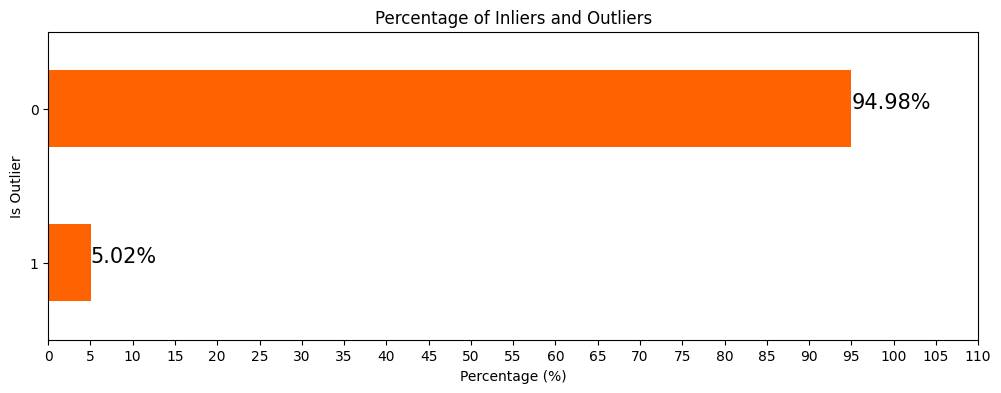

In [ ]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
customer_data_cleaned.shape

(4067, 16)

# Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,12347,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,12348,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,12349,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,12350,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


In [ ]:
customer_data_scaled.reset_index(inplace=True)

customer_data_scaled.head()

,index,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,0,12346,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,1,12347,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,2,12348,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,3,12349,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,4,12350,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


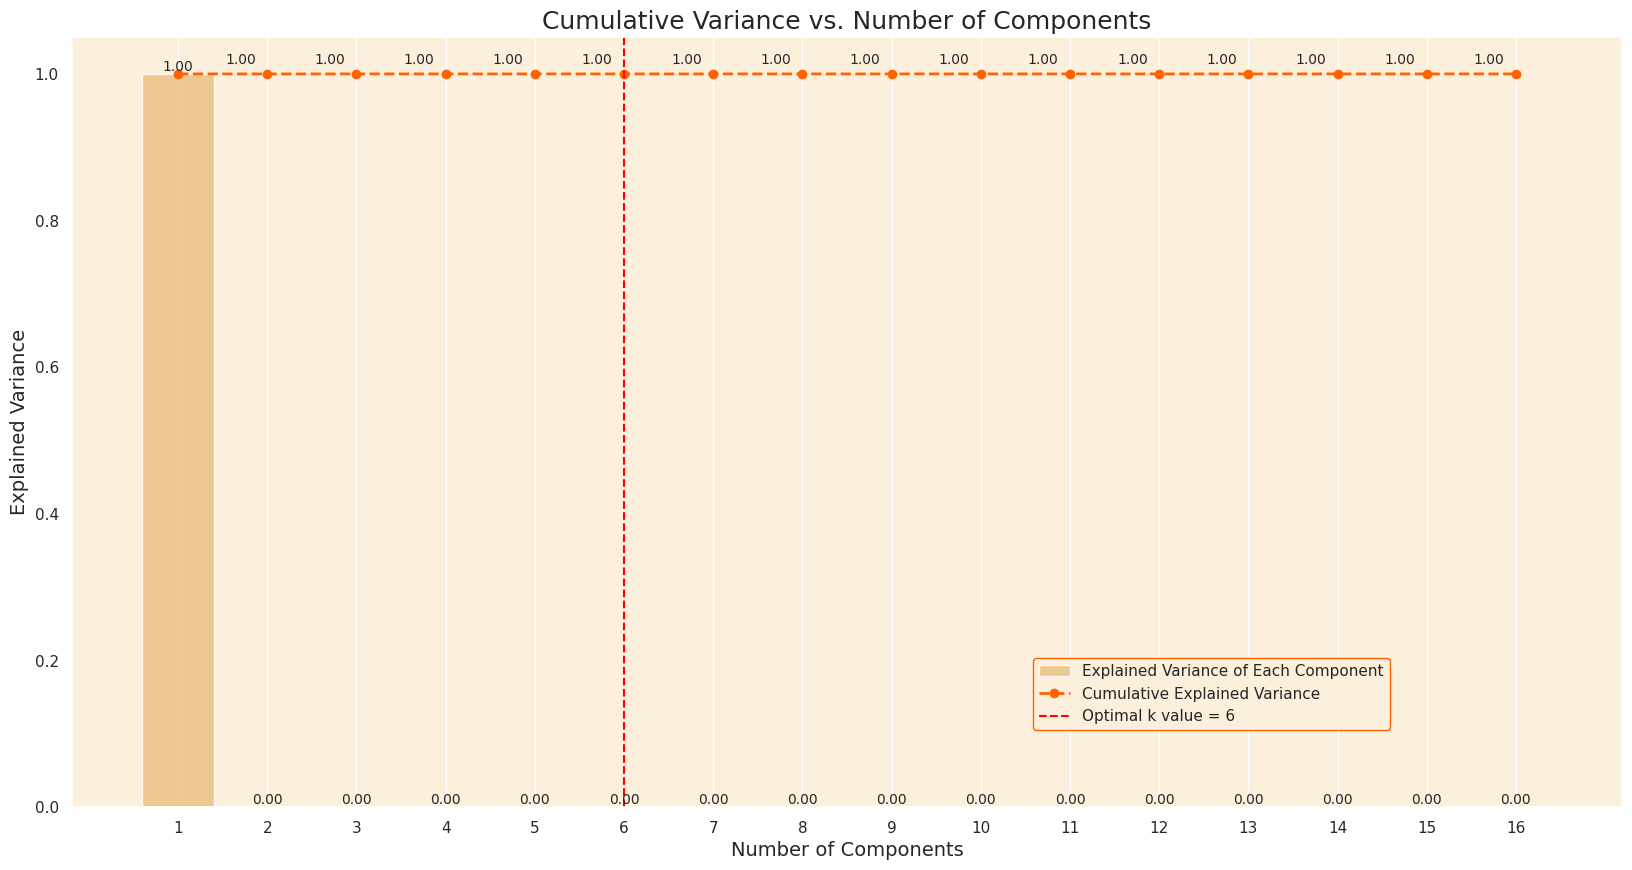

In [ ]:
from sklearn.decomposition import PCA

# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

The plot and the cumulative explained variance values indicate how much of the total variance in the dataset is captured by each principal component, as well as the cumulative variance explained by the first n components.

Here, we can observe that:

The first component explains approximately 28% of the variance.

The first two components together explain about 49% of the variance.

The first three components explain approximately 61% of the variance, and so on.

Considering the context of customer segmentation, we want to retain a sufficient amount of information to identify distinct customer groups effectively. Therefore, retaining the first 6 components might be a balanced choice, as they together explain a substantial portion of the total variance while reducing the dimensionality of the dataset.

In [ ]:
from sklearn.decomposition import PCA

# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [ ]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346,-2032.999794,-2.334703,-1.701093,-1.727987,-0.889264,-0.441044
12347,-2032.000347,3.136048,-1.383781,1.801574,0.982610,-0.202246
12348,-2030.999997,0.436069,0.588869,0.541454,0.605649,-0.565275
12349,-2030.000769,1.618425,-2.690987,5.698078,-0.606692,0.643728
12350,-2028.999883,-2.148003,-0.538243,0.440137,-0.296881,-1.544087


In [ ]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  blue' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

,PC1,PC2,PC3,PC4,PC5,PC6
index,1.000000,0.000073,-0.000002,0.000067,-0.000051,0.000050
Days_Since_Last_Purchase,0.000004,-0.218325,-0.013926,0.065823,-0.295500,-0.212048
Total_Transactions,0.000003,0.381367,0.014643,-0.257011,0.134852,-0.038628
Total_Products_Purchased,-0.000027,0.401457,0.007293,0.070946,0.140549,0.038027
Total_Spend,-0.000038,0.431082,0.010090,0.066478,0.094913,0.010762
Average_Transaction_Value,-0.000077,0.173981,-0.015476,0.587584,-0.108044,0.035570
Unique_Products_Purchased,0.000031,0.326491,0.063231,0.019432,0.190394,-0.215853
Average_Days_Between_Purchases,0.000004,-0.022471,-0.036010,-0.128337,0.263981,0.729986
Day_Of_Week,-0.000005,-0.026640,0.994664,-0.007628,-0.017293,0.058772
Hour,0.000064,-0.022429,0.056321,0.004083,0.124738,-0.529356


# K means

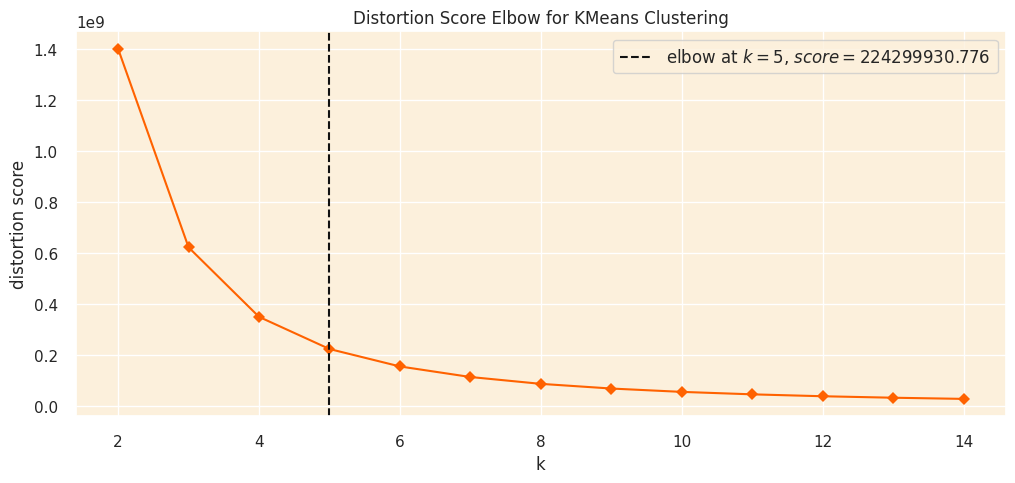

In [ ]:
# Elbow method to determine clusters

from yellowbrick.cluster import KElbowVisualizer
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

Elbow method gives us 5 as optimal clustes but it can be anywhere between 3 and 7.

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.gridspec as gridspec
from sklearn.metrics import silhouette_score

def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

<ipython-input-83-580b1a4ac066>:63: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


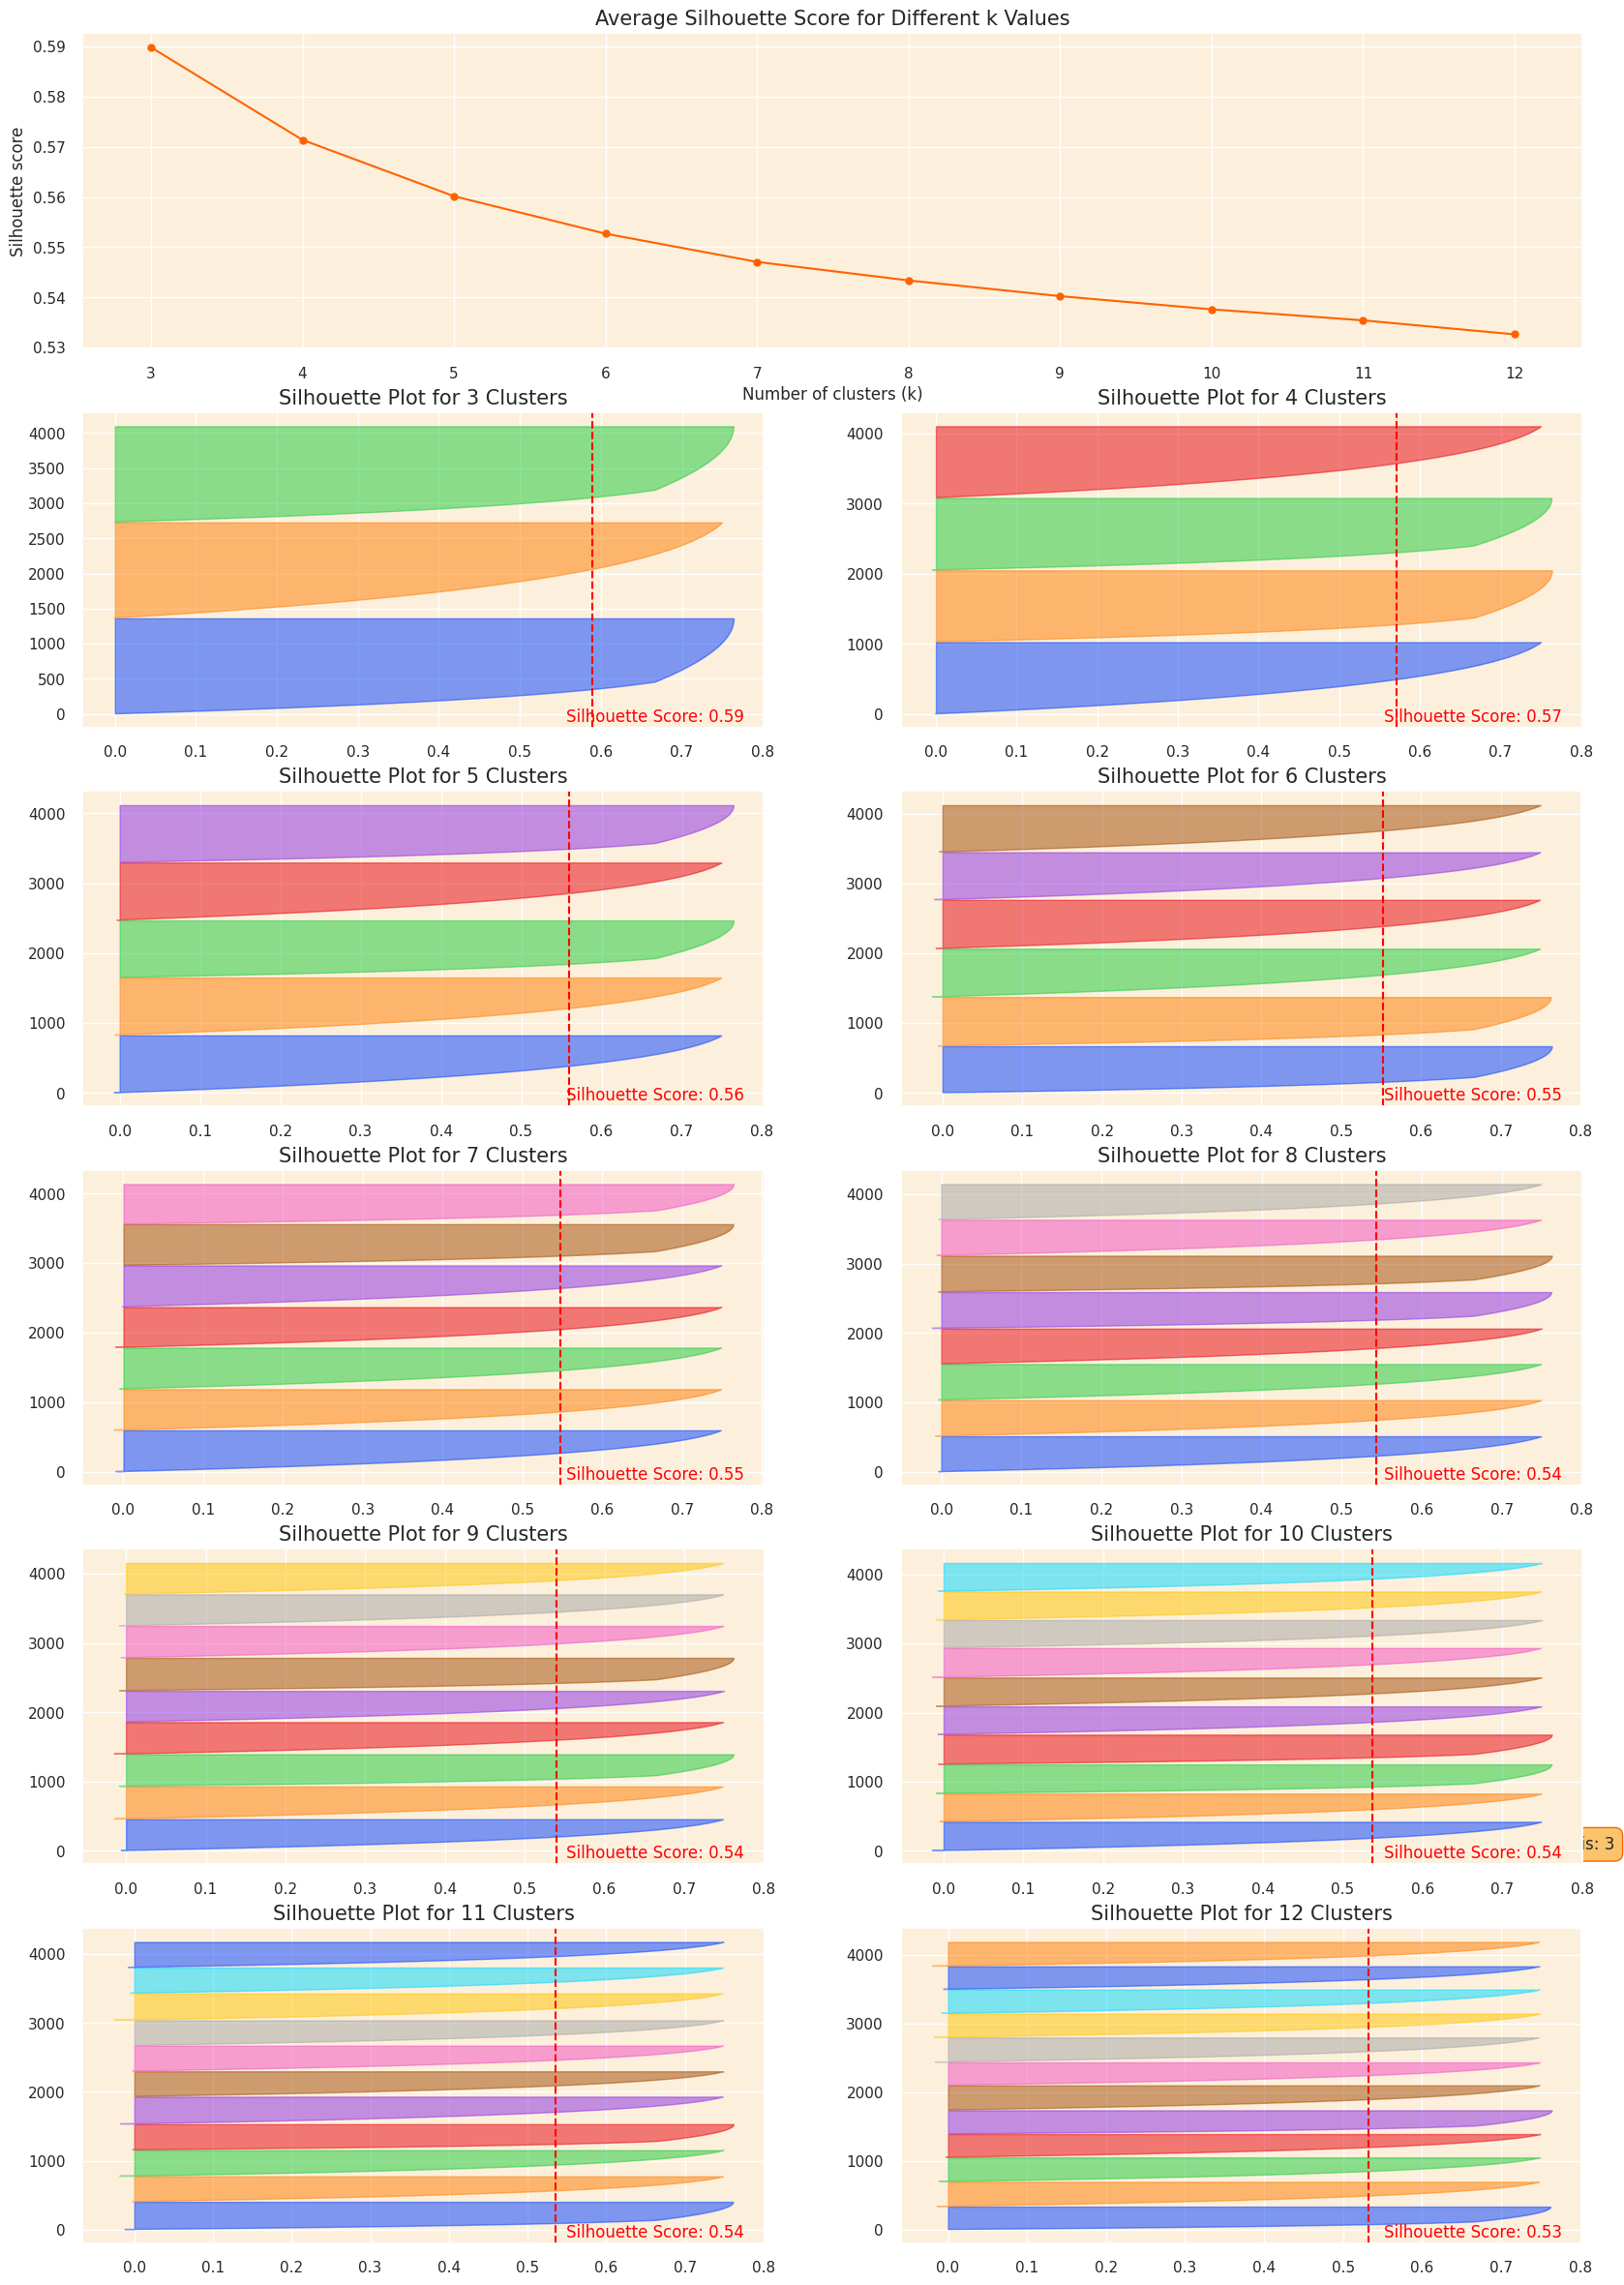

In [ ]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

K value with highest silhouette score is 3 so taking 3 as number of clusters.

In [ ]:
from collections import Counter

# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [ ]:
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1
1,12347,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1
2,12348,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1
3,12349,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1
4,12350,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1


In [ ]:
import plotly.graph_objects as go

# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'],
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'],
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'],
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

<ipython-input-88-4e2adce43589>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




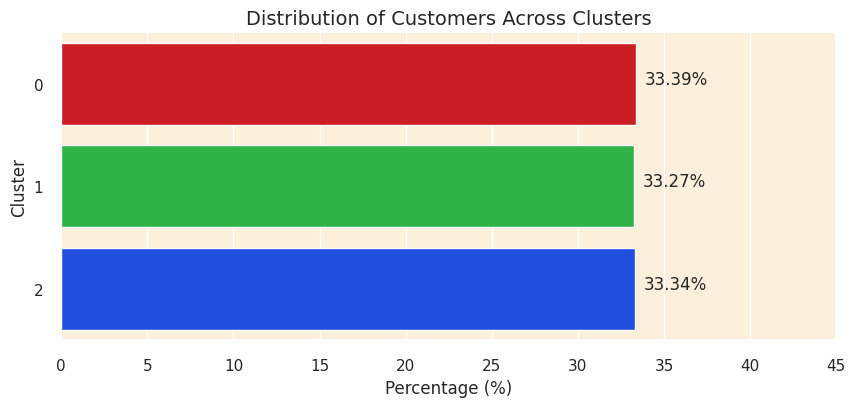

In [ ]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from tabulate import tabulate

# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        4067        |
|    Silhouette Score     | 0.5898242046404684 |
| Calinski Harabasz Score | 16254.58074293745  |
|  Davies Bouldin Score   | 0.5000825269085674 |
+-------------------------+--------------------+


Silhouette Score: 0.59

Interpretation: A Silhouette Score measures how well each point fits within its own cluster compared to other clusters. The score ranges from -1 to 1:
A score close to 1 indicates that clusters are well-separated, with each point being much closer to other points in the same cluster than to points in other clusters.
A score close to 0 suggests that the points are on or near the decision boundary between clusters.
A score close to -1 indicates that points are likely misclassified (i.e., they are closer to a different cluster than their own).
What it means: A score of 0.59 indicates moderate to good separation between the clusters. While it's not perfect, it's a decent score, suggesting that your clusters are fairly distinct, with minimal overlap.

Calinski-Harabasz Score: 16254.58

Interpretation: The Calinski-Harabasz Score (also known as the Variance Ratio Criterion) measures the ratio of the sum of between-cluster dispersion to within-cluster dispersion. Higher values indicate that clusters are well-separated and compact.
A higher score suggests that the clusters are well-defined.
A lower score indicates that the clusters might be poorly separated.
What it means: A score of 16254.58 is quite high, indicating that the clusters are well-separated and compact. This suggests that the clustering has effectively captured meaningful structure in the data.

Davies-Bouldin Score: 0.50

Interpretation: The Davies-Bouldin Score evaluates the average similarity ratio of each cluster with the cluster that is most similar to it. Lower values indicate better clustering, as they reflect less overlap between clusters.
A lower Davies-Bouldin Score implies that the clusters are more distinct.
A higher Davies-Bouldin Score indicates that the clusters are more similar to each other and may not be well-separated.
What it means: A score of 0.50 is relatively low, suggesting that the clusters are reasonably well-separated, with only moderate overlap. This is a good score, and it further reinforces the idea that your clustering results are solid.

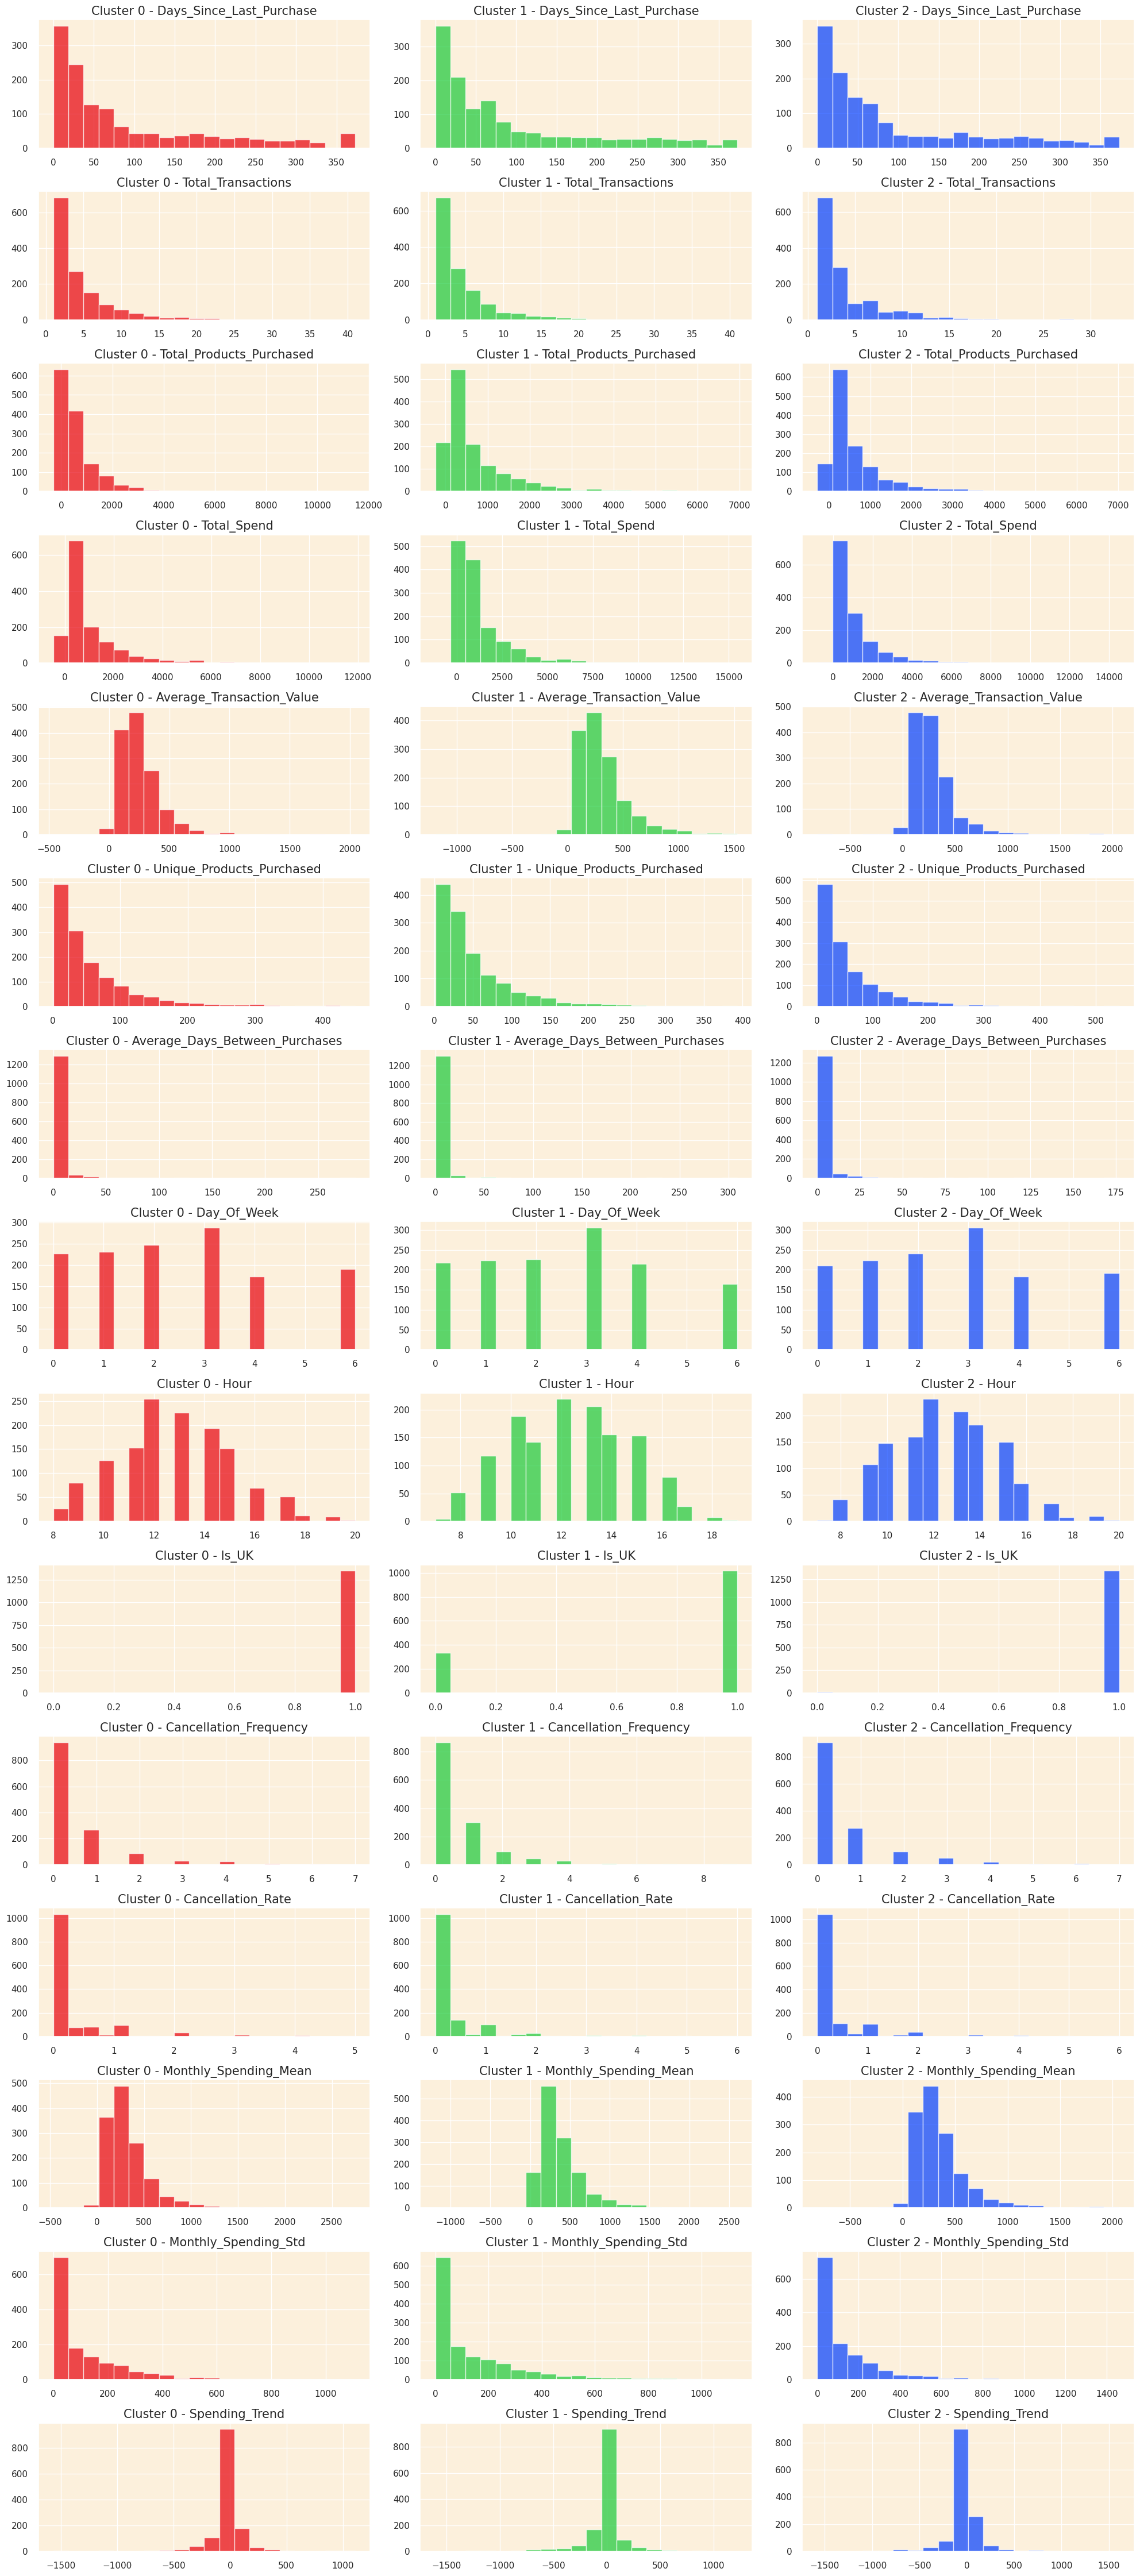

In [ ]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

# Recommendation

In [ ]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) &
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)

        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')



In [ ]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
17702.0,22616,PACK OF 12 LONDON TISSUES,16014,SMALL CHINESE STYLE SCISSOR,84879,ASSORTED COLOUR BIRD ORNAMENT
17697.0,22616,PACK OF 12 LONDON TISSUES,16014,SMALL CHINESE STYLE SCISSOR,84879,ASSORTED COLOUR BIRD ORNAMENT
14880.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
14863.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85123A,WHITE HANGING HEART T-LIGHT HOLDER
13978.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,85099B,JUMBO BAG RED RETROSPOT,21212,PACK OF 72 RETROSPOT CAKE CASES
17081.0,22616,PACK OF 12 LONDON TISSUES,16014,SMALL CHINESE STYLE SCISSOR,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
15797.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85099B,JUMBO BAG RED RETROSPOT
12516.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,21212,PACK OF 72 RETROSPOT CAKE CASES,15036,ASSORTED COLOURS SILK FAN
16230.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,85099B,JUMBO BAG RED RETROSPOT
